# Load Dependencies

In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from pyvirtualdisplay import Display
import wandb

import sys
sys.path.append('..')
from components.uncert_agents import make_agent
from shared.components.env import Env
from shared.utils.noise import add_noise

In [2]:
wandb.init()

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: W&B syncing is set to `offline` in this directory.  Run `wandb online` or set WANDB_MODE=online to enable cloud syncing.


# Variables Initialization

In [3]:
def make_soft_actions(actions: list, factor: float):
    soft_actions = np.array(actions) * factor
    return tuple(soft_actions.tolist())

In [4]:
skip_zoom = 50
noise_steps = 50
noise_evals = 100
noise_range = [0, 0.1]
args_actions = "0.25,0.5"
image_stack = 4

base_path = 'images/test'
test_img_paths = [
    'farquad.jpg', 'galleta.png', 'homer.png', 'hongo.png', 'lion.png', 'paisaje.png', 'paisaje2.png', 'random.png', 'random2.png', 'shrek.png'
]

STEER_RANGE = [-0.5, 0.5]
THROTTLE_RANGE = [0, 1]
BRAKE_RANGE = [0, 0.2]
do_nothing_action = tuple([[0, THROTTLE_RANGE[0], BRAKE_RANGE[0]]])
full_actions = (
    [STEER_RANGE[0], THROTTLE_RANGE[0], BRAKE_RANGE[0]],  # Turn Left
    [STEER_RANGE[1], THROTTLE_RANGE[0], BRAKE_RANGE[0]],  # Turn Right
    [0, THROTTLE_RANGE[0], BRAKE_RANGE[1]],  # Full Break
    [0, THROTTLE_RANGE[1], BRAKE_RANGE[0]],  # Accelerate
    [STEER_RANGE[0], THROTTLE_RANGE[1], BRAKE_RANGE[0]],  # Left accelerate
    [STEER_RANGE[1], THROTTLE_RANGE[1], BRAKE_RANGE[0]],  # Right accelerate
    [STEER_RANGE[0], THROTTLE_RANGE[0], BRAKE_RANGE[1]],  # Left break
    [STEER_RANGE[1], THROTTLE_RANGE[0], BRAKE_RANGE[1]],  # Right break
)
alter_actions = ()
args_actions = [float(i.strip()) for i in args_actions.split(',')]
for mult in args_actions:
    alter_actions += make_soft_actions(full_actions, mult)
actions = (
    do_nothing_action
    + full_actions
    + alter_actions
)

In [5]:
def load_agent(
    path, model, nb_nets):
    agent = make_agent(
        model,
        nb_nets,
        image_stack,
        actions,
        0.001,
        0.95,
        None,
        None,
        64,
        device=device,
        clip_grad=False,
    )
    agent.load_param(path, eval_mode=True)
    return agent

def scale_state(
    state: np.array, lower: float=-1, upper: float=1, 
    target_lower: float=0, target_upper: float=255, as_int: bool=True):
    norm = (state - lower) * (upper - lower)
    unnorm = norm * (target_upper - target_lower) + target_lower
    if as_int:
        return unnorm.astype(np.uint8)
    return unnorm

def read_image(path):
    img = plt.imread(f'{base_path}/{path}').astype(np.float32)
    img = scale_state(img, lower=0, upper=1, target_lower=-1, target_upper=1, as_int=False)
    img = np.transpose(img, axes=[2, 0, 1])
    img = np.repeat(img, 2, axis=0)[:4, :, :]
    return img

In [6]:
def noise_sweep(agent, state, noise_range, noise_steps, noise_evals):
    noises = np.linspace(noise_range[0], noise_range[-1], num=noise_steps)
    epistemics = []
    aleatorics = []
    for noise_var in noises:
        mean_epistemic = 0
        mean_aleatoric = 0
        for _ in range(noise_evals):
            noisy_state = add_noise(state, noise_var)
            (epistemic, aleatoric) = agent.select_action(noisy_state, greedy=True)[-1]
            mean_epistemic += epistemic.view(-1).cpu().numpy()[0] / noise_evals
            mean_aleatoric += aleatoric.view(-1).cpu().numpy()[0] / noise_evals
        epistemics.append(mean_epistemic)
        aleatorics.append(mean_aleatoric)
    epistemics = np.array(epistemics)
    aleatorics = np.array(aleatorics)
    return noises, epistemics, aleatorics

def ood_sweep(test_img_paths, skip_zoom, env, agent):
    id_uncerts = []
    ood_uncerts = []

    for path in test_img_paths:
        test_image = read_image(path)
        ood_uncert = agent.select_action(test_image, greedy=True)[-1]
        unc = ood_uncert[0].view(-1).cpu().numpy()[0]
        if np.isinf(unc):
            unc = -1
        ood_uncerts.append(unc)
        
    for _ in range(100):
        state = env.reset()
        if skip_zoom is not None:
            for _ in range(skip_zoom):
                state = env.step([0, 0, 0])[0]
        id_uncert = agent.select_action(state, greedy=True)[-1]
        id_uncerts.append(id_uncert[0].view(-1).cpu().numpy()[0])
    return id_uncerts, ood_uncerts

In [7]:
# Virtual display
display = Display(visible=0, size=(1400, 900))
display.start()

In [8]:
# Whether to use cuda or cpu
torch.cuda.empty_cache()
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
torch.manual_seed(0)
if use_cuda:
    torch.cuda.manual_seed(0)
np.random.seed(0)

In [9]:
env = Env(
    img_stack=image_stack,
    action_repeat=8,
    seed=0,
    noise=0,
)

/home/user/miniconda/lib/python3.8/site-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


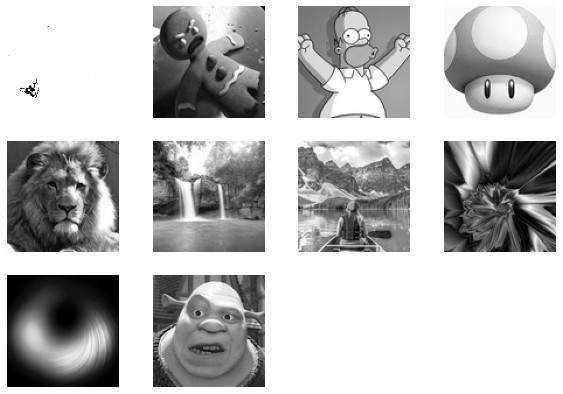

In [10]:
# create figure
fig = plt.figure(figsize=(10, 7))
  
# setting values to rows and column variables
rows = 3
columns = 4

for idx, img_path in enumerate(test_img_paths):
    test_image = read_image(img_path)
    # Adds a subplot at the 2nd position
    fig.add_subplot(rows, columns, idx + 1)
    
    # showing image
    plt.imshow(test_image[3, :, :], cmap='gray', vmin=-1, vmax=1)
    plt.axis('off')

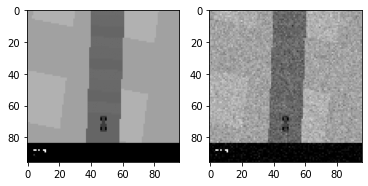

In [20]:
state = env.reset()
if skip_zoom is not None:
    for _ in range(skip_zoom):
        state = env.step([0, 0, 0])[0]

fix, ax = plt.subplots(1, 2)
ax[0].imshow(state[-1, :, :], cmap='gray', vmin=-1, vmax=1)
noisy_state = add_noise(state, noise_range[-1])
ax[1].imshow(noisy_state[-1, :, :], cmap='gray', vmin=-1, vmax=1)

# Models Evaluation

## Base

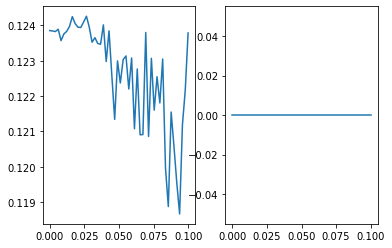

In [27]:
agent = load_agent('param/best_ddqn_base_c077a8fa-b895-4aeb-85f6-0396baaf46c7.pkl', 'base', 10)
noises, epistemics, aleatorics = noise_sweep(agent, state, noise_range, noise_steps, noise_evals)

fig, ax = plt.subplots(1, 2)
ax[0].plot(noises, epistemics)
ax[1].plot(noises, aleatorics)

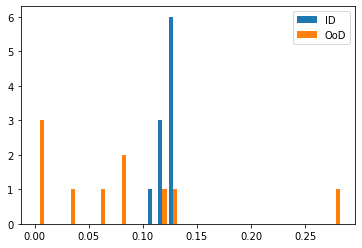

In [32]:
id_uncerts, ood_uncerts = ood_sweep(test_img_paths, skip_zoom, env, agent)
bins = 30
plt.figure()
plt.hist([id_uncerts, ood_uncerts], bins, label=['ID', 'OoD'])
plt.legend(loc='upper right')
plt.show()

## Dropout

[0.         0.00204082 0.00408163 0.00612245 0.00816327 0.01020408
 0.0122449  0.01428571 0.01632653 0.01836735 0.02040816 0.02244898
 0.0244898  0.02653061 0.02857143 0.03061224 0.03265306 0.03469388
 0.03673469 0.03877551 0.04081633 0.04285714 0.04489796 0.04693878
 0.04897959 0.05102041 0.05306122 0.05510204 0.05714286 0.05918367
 0.06122449 0.06326531 0.06530612 0.06734694 0.06938776 0.07142857
 0.07346939 0.0755102  0.07755102 0.07959184 0.08163265 0.08367347
 0.08571429 0.0877551  0.08979592 0.09183673 0.09387755 0.09591837
 0.09795918 0.1       ]
[0.00026667 0.00026667 0.00026667 0.00026667 0.00026667 0.00026667
 0.00026667 0.00026667 0.00026667 0.00026667 0.00026667 0.00026667
 0.00026667 0.00026667 0.00026667 0.00026667 0.00026667 0.00026667
 0.00026667 0.00026667 0.00026667 0.00026667 0.00026667 0.00026667
 0.00026667 0.00026667 0.00026667 0.00026667 0.00026667 0.00026667
 0.00026667 0.00026667 0.00026667 0.00026667 0.00026667 0.00026667
 0.00026667 0.00026667 0.00026667 0.00

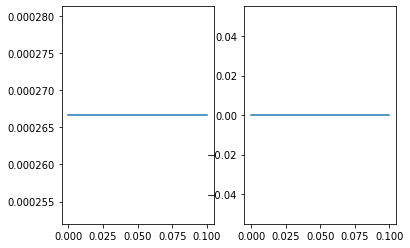

In [42]:
agent = load_agent('param/best_ddqn_dropout_481dd29d-3ecc-48aa-9249-31896c98036f.pkl', 'dropout', 25)
noises, epistemics, aleatorics = noise_sweep(agent, state, noise_range, noise_steps, noise_evals)

print(noises)
print(epistemics)
print(aleatorics)
fig, ax = plt.subplots(1, 2)
ax[0].plot(noises, epistemics)
ax[1].plot(noises, aleatorics)

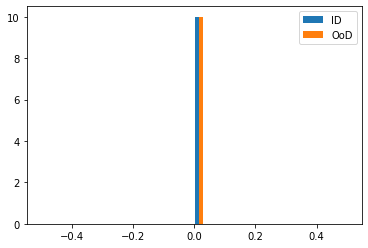

In [44]:
id_uncerts, ood_uncerts = ood_sweep(test_img_paths, skip_zoom, env, agent)
bins = 30
plt.figure()
plt.hist([id_uncerts, ood_uncerts], bins, label=['ID', 'OoD'])
plt.legend(loc='upper right')
plt.show()

## Bootstrap

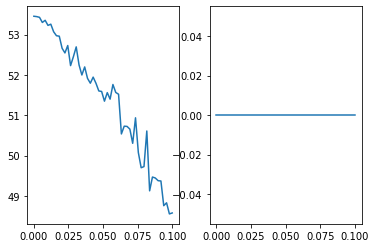

In [48]:

agent = load_agent('param/best_ddqn_bootstrap_8b9714f5-5aee-4427-9e62-383c0b2d0ccc.pkl', 'bootstrap', 5)
noises, epistemics, aleatorics = noise_sweep(agent, state, noise_range, noise_steps, noise_evals)

fig, ax = plt.subplots(1, 2)
ax[0].plot(noises, epistemics)
ax[1].plot(noises, aleatorics)

In [49]:
id_uncerts, ood_uncerts = ood_sweep(test_img_paths, skip_zoom, env, agent)
bins = 30
plt.figure()
plt.hist([id_uncerts, ood_uncerts], bins, label=['ID', 'OoD'])
plt.legend(loc='upper right')
plt.show()

ValueError: Expected parameter scale (Tensor of shape (5, 25)) of distribution Normal(loc: torch.Size([5, 25]), scale: torch.Size([5, 25])) to satisfy the constraint GreaterThan(lower_bound=0.0), but found invalid values:
tensor([[inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, 0., inf, 0., 0., inf, inf, inf, inf, inf, inf, inf, inf, 0., inf,
         inf],
        [inf, inf, inf, 0., inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, 0., inf, inf,
         inf],
        [inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf,
         inf],
        [inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf,
         inf],
        [inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf,
         inf]], device='cuda:0')

## Sensitivity

In [11]:
agent = load_agent('param/checkpoint_ddqn_sensitivity_03ec9544-d59e-4a64-9dc3-7997dbd74d4d.pkl', 'sensitivity', 100)

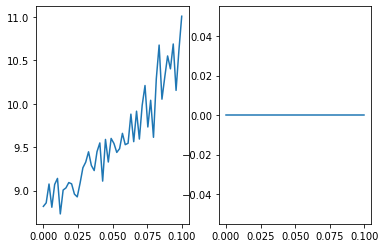

In [50]:
noises, epistemics, aleatorics = noise_sweep(agent, state, noise_range, noise_steps, noise_evals)

fig, ax = plt.subplots(1, 2)
ax[0].plot(noises, epistemics)
ax[1].plot(noises, aleatorics)

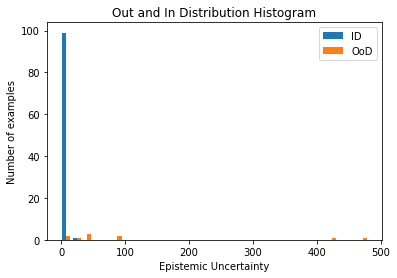

In [12]:
id_uncerts, ood_uncerts = ood_sweep(test_img_paths, skip_zoom, env, agent)
bins = 30
plt.figure()
plt.hist([id_uncerts, ood_uncerts], bins, label=['ID', 'OoD'])
plt.legend(loc='upper right')
plt.title('Out and In Distribution Histogram')
plt.ylabel('Number of examples')
plt.xlabel('Epistemic Uncertainty')
plt.show()

## VAE

In [13]:
agent = load_agent('param/best_ddqn_vae_c3e688f6-e9d6-4dc9-94ad-27b66938ea3c.pkl', 'vae', 10)

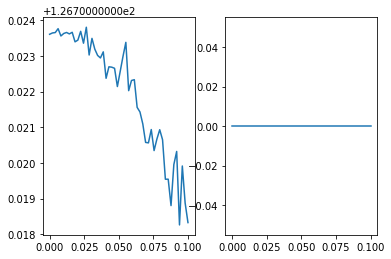

In [52]:
noises, epistemics, aleatorics = noise_sweep(agent, state, noise_range, noise_steps, noise_evals)

fig, ax = plt.subplots(1, 2)
ax[0].plot(noises, epistemics)
ax[1].plot(noises, aleatorics)

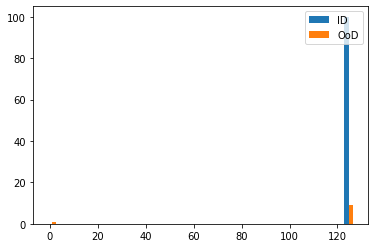

In [14]:
id_uncerts, ood_uncerts = ood_sweep(test_img_paths, skip_zoom, env, agent)
bins = 30
plt.figure()
plt.hist([id_uncerts, ood_uncerts], bins, label=['ID', 'OoD'])
plt.legend(loc='upper right')
plt.show()